In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 4
commitnumber = d62b618
conc = 0.0004
dv = 0.005
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [8, 8]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 294
vmax = 980
vmin = 800
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

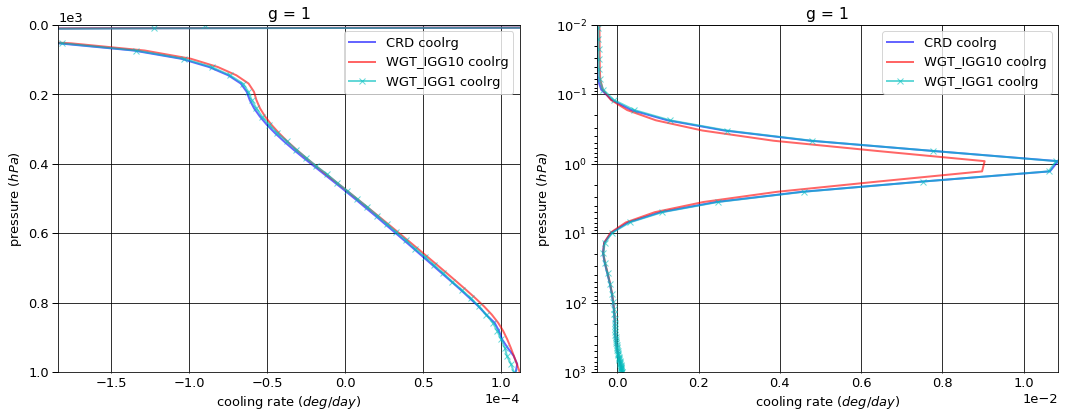

# Figure: cooling rate g-group 2

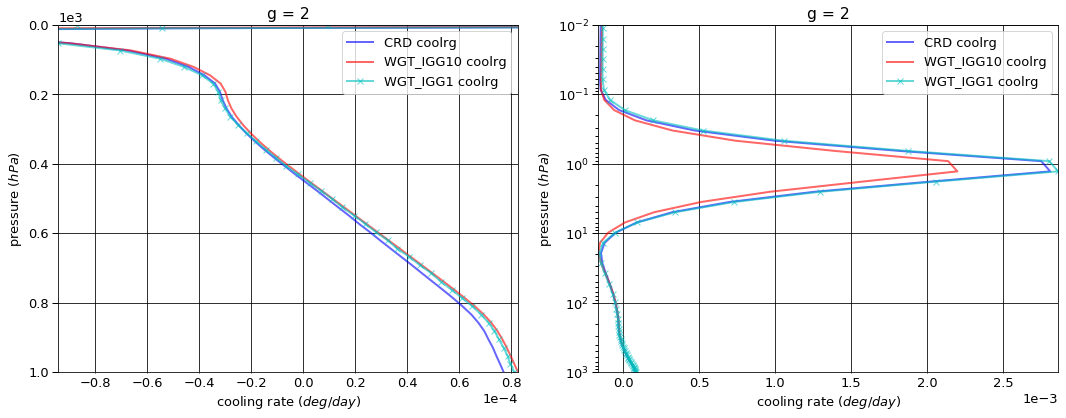

# Figure: cooling rate g-group 3

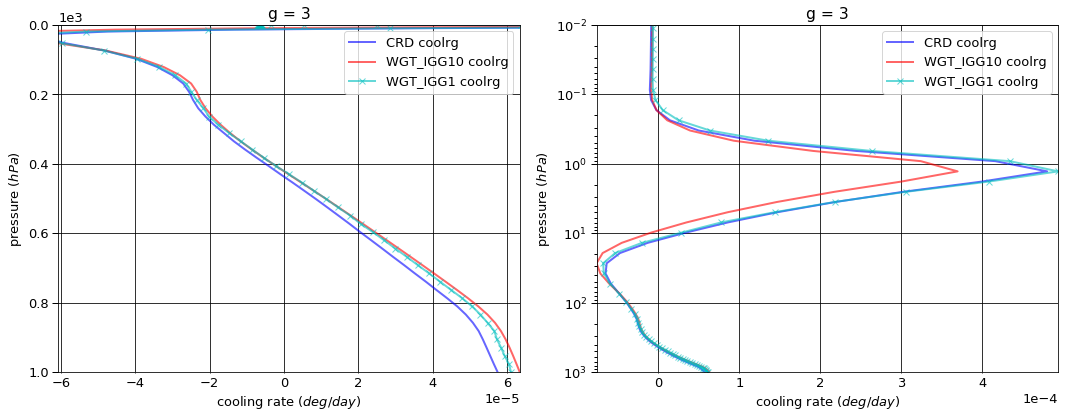

# Figure: cooling rate g-group 4

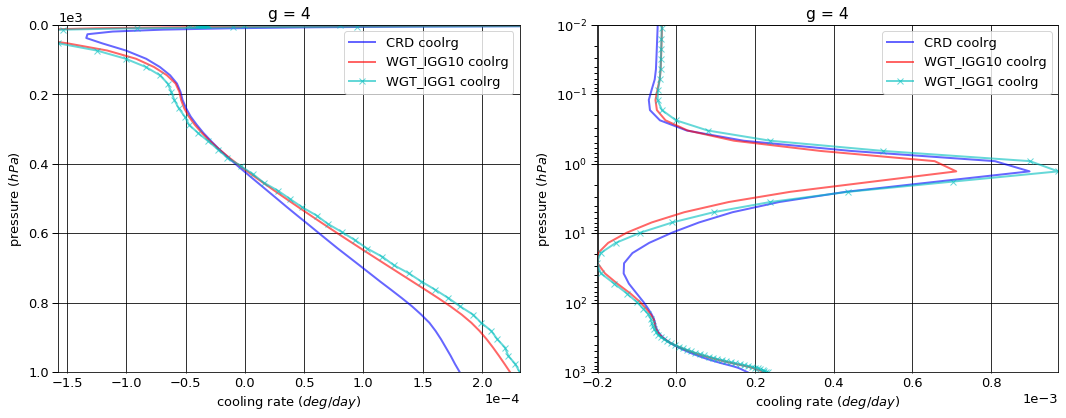

# Figure: cooling rate g-group 5

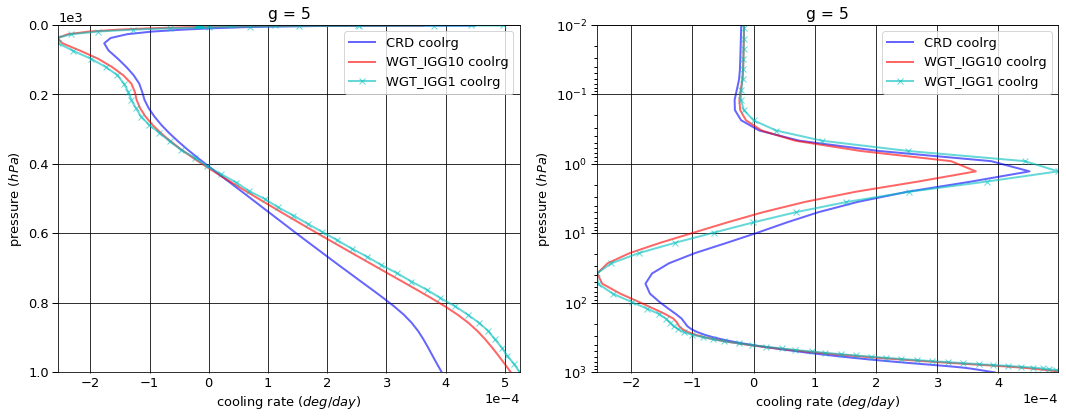

# Figure: cooling rate g-group 6

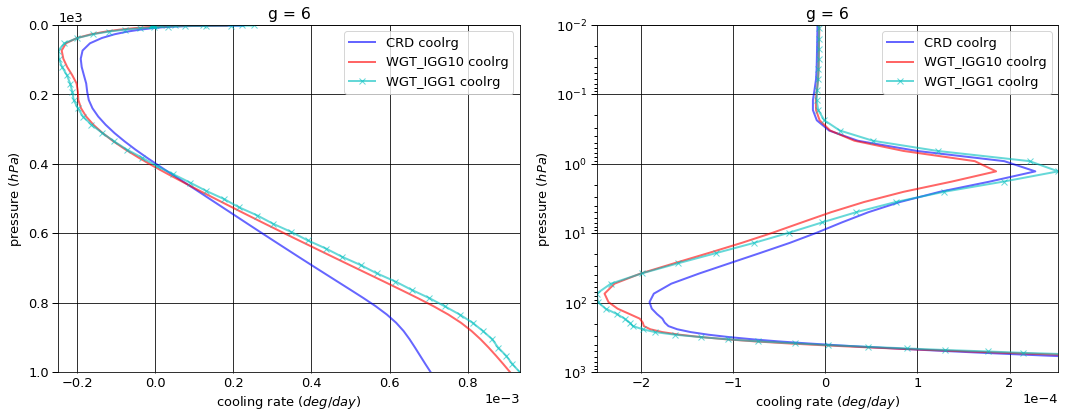

# Figure: cooling rate g-group 7

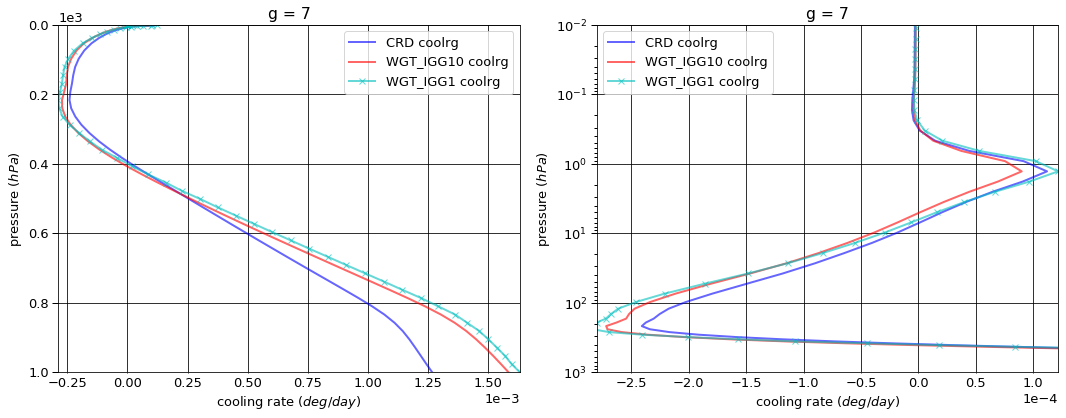

# Figure: cooling rate g-group 8

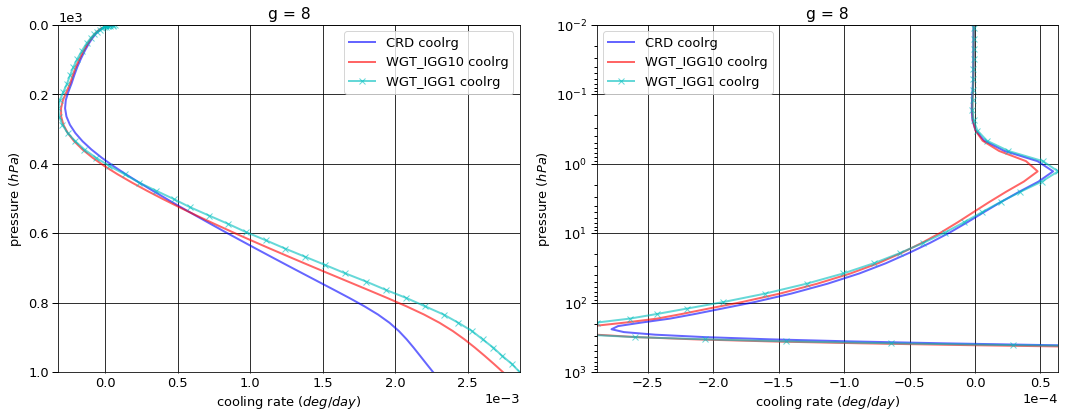

# Figure: cooling rate g-group 9

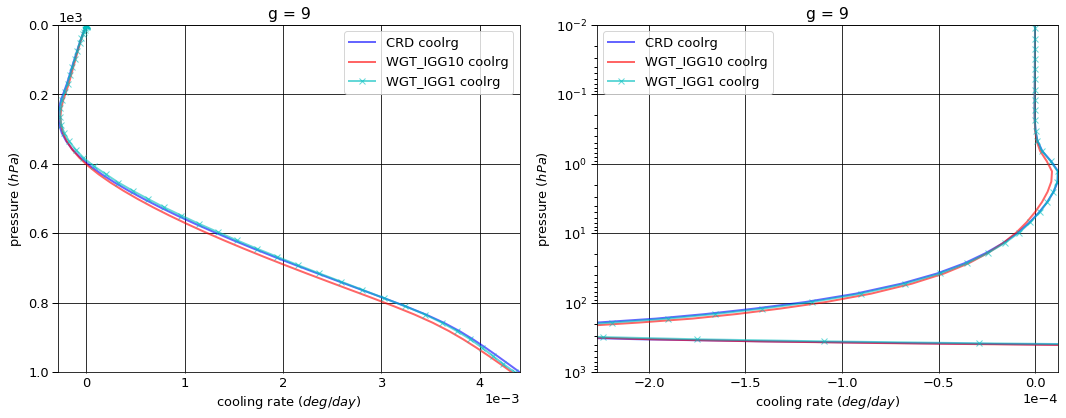

# Figure: cooling rate g-group 10

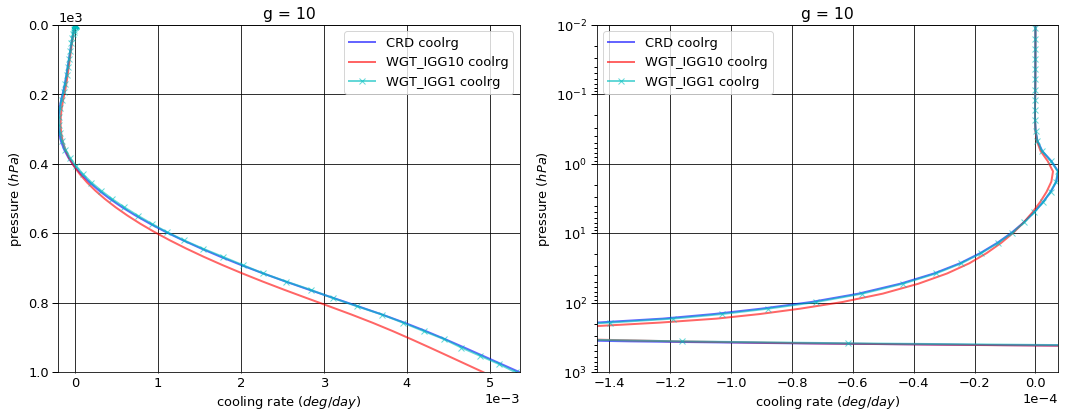

# Figure: cooling rate g-group 11

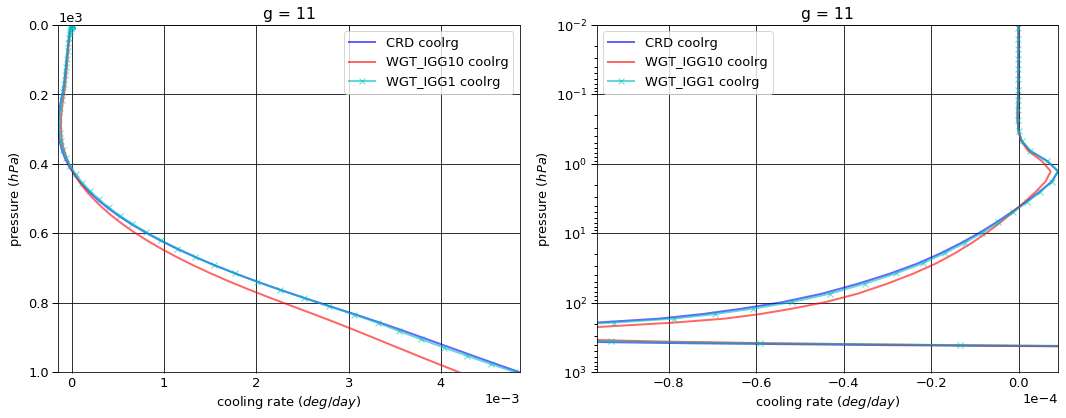

# Figure: cooling rate g-group 12

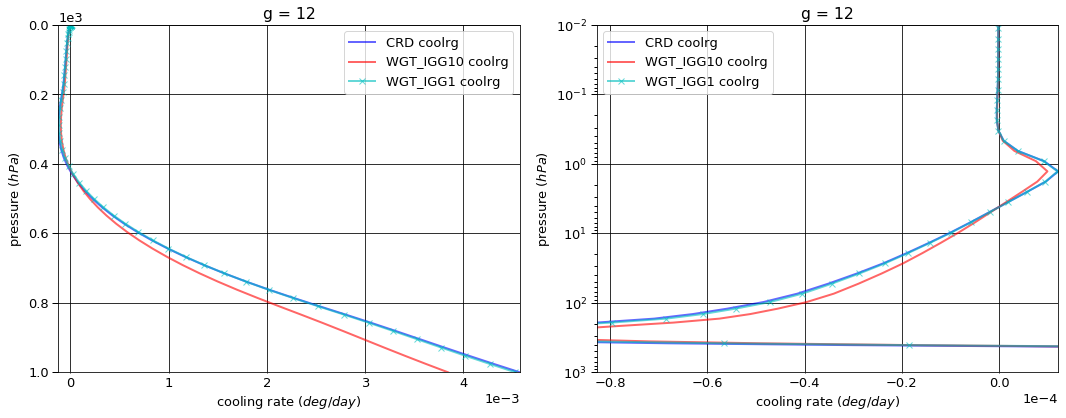

# Figure: cooling rate g-group 13

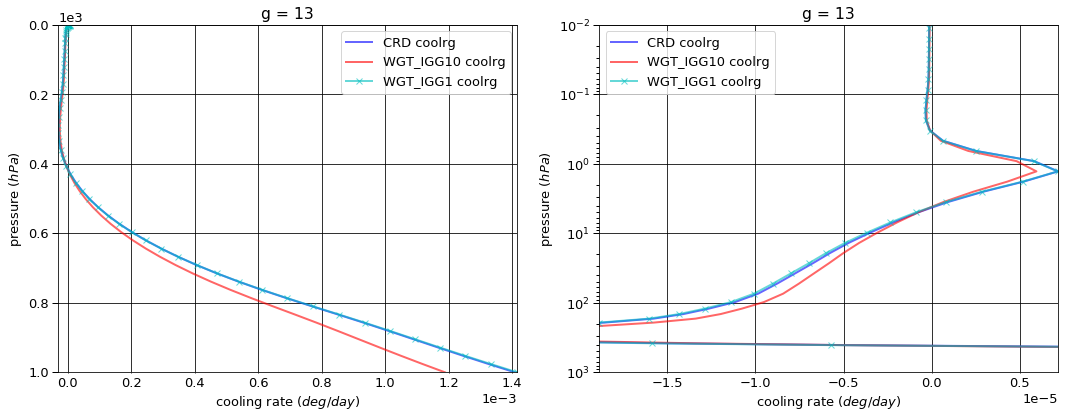

# Figure: cooling rate g-group 14

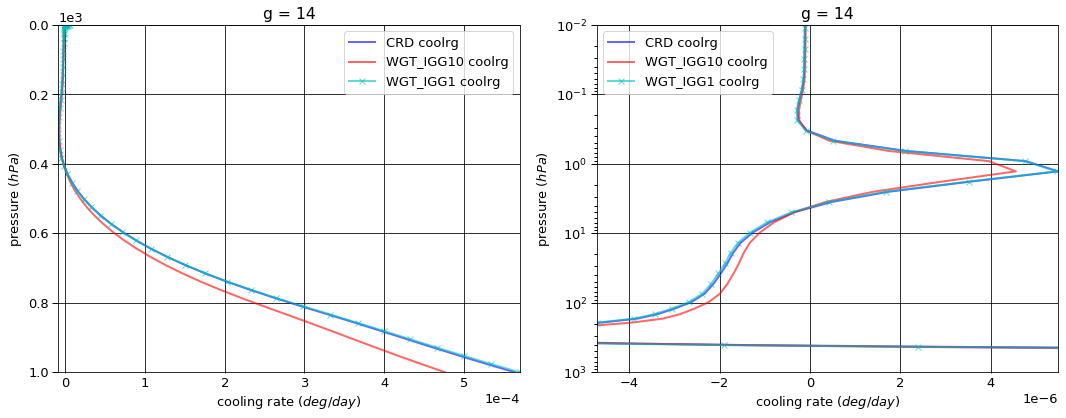

# Figure: cooling rate g-group 15

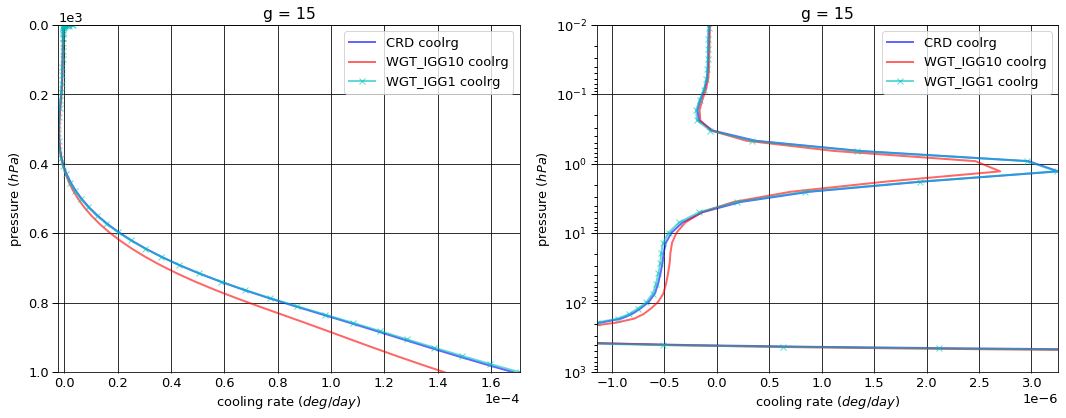

# Figure: cooling rate g-group 16

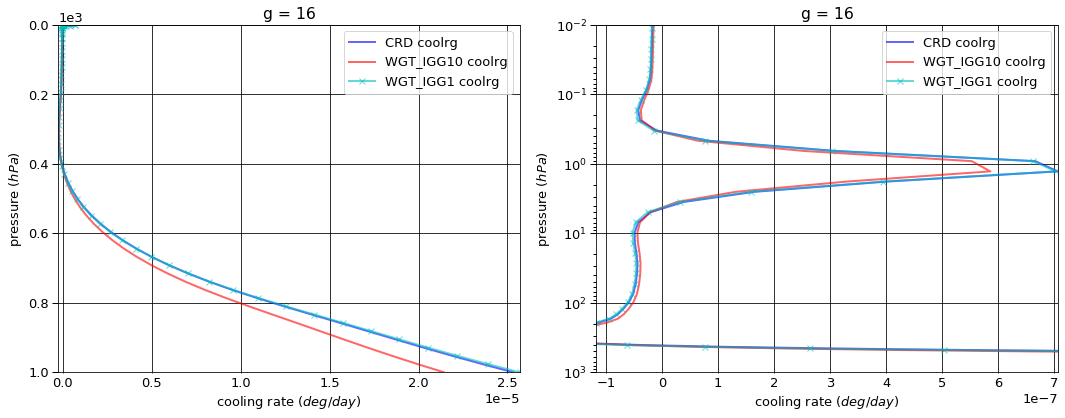

# Figure: cooling rate g-group total

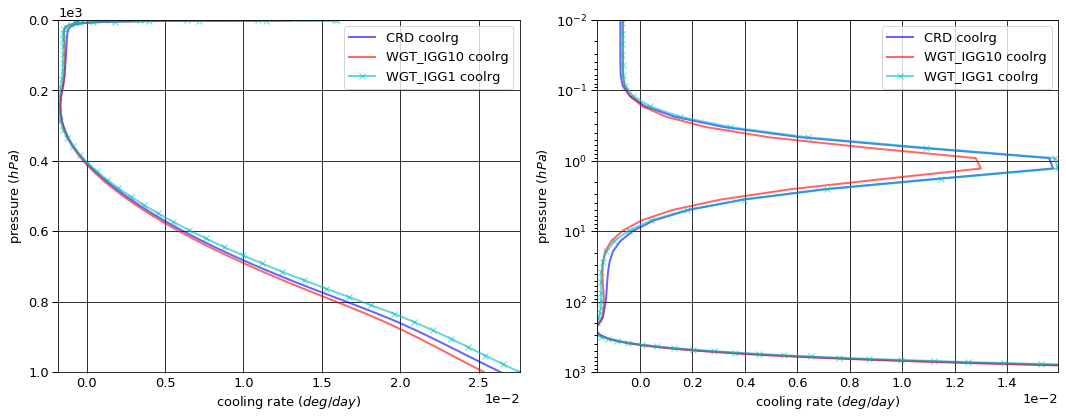

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.016252  0.000000  -0.016252
   1013.0   76     -0.024938  0.011462  -0.013476
2  0.0      1      -0.017579  0.000000  -0.017579
   1013.0   76     -0.022828  0.007060  -0.015768
3  0.0      1      -0.010624  0.000000  -0.010624
   1013.0   76     -0.014460  0.005059  -0.009400
4  0.0      1      -0.090358  0.000000  -0.090358
   1013.0   76     -0.099409  0.013689  -0.085720
5  0.0      1      -0.181613  0.000000  -0.181613
   1013.0   76     -0.199697  0.029595  -0.170102
6  0.0      1      -0.308089  0.000000  -0.308089
   1013.0   76     -0.336717  0.051720  -0.284997
7  0.0      1      -0.536061  0.000000  -0.536061
   1013.0   76     -0.579980  0.088976  -0.491004
8  0.0      1      -1.021181  0.000000  -1.021181
   1013.0   76     -1.081738  0.144825  -0.936913
9  0.0      1      -0.984440  0.000000  -0.984440
   1013.0   76     -1.063160  0.235626  -0.827534
10 0.0      1      -2.284079  0.000000  -2.284079
   1013.0   76     -2.346892  0.230289  -2.116603
11 0.0      1      -5.274996  0.000000  -5.274996
   1013.0   76     -5.321003  0.185456  -5.135547
12 0.0      1     -13.702434  0.000000 -13.702434
   1013.0   76    -13.742402  0.167140 -13.575261
13 0.0      1     -11.303827  0.000000 -11.303827
   1013.0   76    -11.314860  0.049966 -11.264894
14 0.0      1     -11.859586  0.000000 -11.859586
   1013.0   76    -11.863398  0.018993 -11.844405
15 0.0      1     -10.012901  0.000000 -10.012901
   1013.0   76    -10.013954  0.005516 -10.008438
16 0.0      1      -3.655670  0.000000  -3.655670
   1013.0   76     -3.655810  0.000789  -3.655021


WGT_IGG10


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.015806  0.000000  -0.015806
   1013.0   76     -0.024678  0.011571  -0.013107
2  0.0      1      -0.016990  0.000000  -0.016990
   1013.0   76     -0.022296  0.007197  -0.015100
3  0.0      1      -0.010238  0.000000  -0.010238
   1013.0   76     -0.014038  0.005287  -0.008751
4  0.0      1      -0.088970  0.000000  -0.088970
   1013.0   76     -0.098559  0.015331  -0.083228
5  0.0      1      -0.180093  0.000000  -0.180093
   1013.0   76     -0.199548  0.033931  -0.165618
6  0.0      1      -0.305336  0.000000  -0.305336
   1013.0   76     -0.335322  0.058723  -0.276600
7  0.0      1      -0.530060  0.000000  -0.530060
   1013.0   76     -0.574270  0.098174  -0.476096
8  0.0      1      -1.018745  0.000000  -1.018745
   1013.0   76     -1.077708  0.155208  -0.922500
9  0.0      1      -0.969890  0.000000  -0.969890
   1013.0   76     -1.038763  0.219843  -0.818920
10 0.0      1      -2.251528  0.000000  -2.251528
   1013.0   76     -2.304590  0.204016  -2.100575
11 0.0      1      -5.178617  0.000000  -5.178617
   1013.0   76     -5.216261  0.157525  -5.058735
12 0.0      1     -13.528978  0.000000 -13.528978
   1013.0   76    -13.561497  0.139584 -13.421914
13 0.0      1     -11.351293  0.000000 -11.351293
   1013.0   76    -11.360586  0.041978 -11.318609
14 0.0      1     -11.984584  0.000000 -11.984584
   1013.0   76    -11.987827  0.015996 -11.971831
15 0.0      1     -10.156752  0.000000 -10.156752
   1013.0   76    -10.157658  0.004655 -10.153003
16 0.0      1      -3.707522  0.000000  -3.707522
   1013.0   76     -3.707643  0.000666  -3.706977


WGT_IGG1


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.016102  0.000000  -0.016102
   1013.0   76     -0.024678  0.011501  -0.013177
2  0.0      1      -0.016914  0.000000  -0.016914
   1013.0   76     -0.022296  0.007360  -0.014936
3  0.0      1      -0.010183  0.000000  -0.010183
   1013.0   76     -0.014038  0.005353  -0.008685
4  0.0      1      -0.088066  0.000000  -0.088066
   1013.0   76     -0.098559  0.016595  -0.081965
5  0.0      1      -0.178244  0.000000  -0.178244
   1013.0   76     -0.199548  0.036554  -0.162994
6  0.0      1      -0.302388  0.000000  -0.302388
   1013.0   76     -0.335322  0.063188  -0.272135
7  0.0      1      -0.525468  0.000000  -0.525468
   1013.0   76     -0.574270  0.105885  -0.468385
8  0.0      1      -1.011788  0.000000  -1.011788
   1013.0   76     -1.077708  0.169373  -0.908335
9  0.0      1      -0.962955  0.000000  -0.962955
   1013.0   76     -1.038763  0.234063  -0.804700
10 0.0      1      -2.243691  0.000000  -2.243691
   1013.0   76     -2.304590  0.228898  -2.075692
11 0.0      1      -5.171893  0.000000  -5.171893
   1013.0   76     -5.216261  0.183366  -5.032895
12 0.0      1     -13.522725  0.000000 -13.522725
   1013.0   76    -13.561497  0.165746 -13.395752
13 0.0      1     -11.349467  0.000000 -11.349467
   1013.0   76    -11.360586  0.050153 -11.310433
14 0.0      1     -11.983942  0.000000 -11.983942
   1013.0   76    -11.987827  0.019153 -11.968674
15 0.0      1     -10.156572  0.000000 -10.156572
   1013.0   76    -10.157658  0.005578 -10.152080
16 0.0      1      -3.707498  0.000000  -3.707498
   1013.0   76     -3.707643  0.000798  -3.706845


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000446  0.000000  0.000446
   1013.0   76     0.000259  0.000110  0.000369
2  0.0      1      0.000589  0.000000  0.000589
   1013.0   76     0.000532  0.000136  0.000668
3  0.0      1      0.000385  0.000000  0.000385
   1013.0   76     0.000422  0.000228  0.000650
4  0.0      1      0.001388  0.000000  0.001388
   1013.0   76     0.000850  0.001642  0.002492
5  0.0      1      0.001520  0.000000  0.001520
   1013.0   76     0.000149  0.004336  0.004485
6  0.0      1      0.002753  0.000000  0.002753
   1013.0   76     0.001395  0.007002  0.008397
7  0.0      1      0.006001  0.000000  0.006001
   1013.0   76     0.005710  0.009197  0.014908
8  0.0      1      0.002436  0.000000  0.002436
   1013.0   76     0.004031  0.010382  0.014413
9  0.0      1      0.014550  0.000000  0.014550
   1013.0   76     0.024397 -0.015783  0.008614
10 0.0      1      0.032550  0.000000  0.032550
   1013.0   76     0.042302 -0.026273  0.016029
11 0.0      1      0.096379  0.000000  0.096379
   1013.0   76     0.104742 -0.027930  0.076811
12 0.0      1      0.173456  0.000000  0.173456
   1013.0   76     0.180905 -0.027557  0.153347
13 0.0      1     -0.047466  0.000000 -0.047466
   1013.0   76    -0.045726 -0.007988 -0.053715
14 0.0      1     -0.124998  0.000000 -0.124998
   1013.0   76    -0.124429 -0.002997 -0.127426
15 0.0      1     -0.143851  0.000000 -0.143851
   1013.0   76    -0.143704 -0.000860 -0.144565
16 0.0      1     -0.051853  0.000000 -0.051853
   1013.0   76    -0.051833 -0.000123 -0.051956


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000150  0.000000  0.000150
   1013.0   76     0.000259  0.000040  0.000299
2  0.0      1      0.000664  0.000000  0.000664
   1013.0   76     0.000532  0.000300  0.000832
3  0.0      1      0.000441  0.000000  0.000441
   1013.0   76     0.000422  0.000294  0.000715
4  0.0      1      0.002292  0.000000  0.002292
   1013.0   76     0.000850  0.002905  0.003756
5  0.0      1      0.003369  0.000000  0.003369
   1013.0   76     0.000149  0.006959  0.007108
6  0.0      1      0.005701  0.000000  0.005701
   1013.0   76     0.001395  0.011468  0.012862
7  0.0      1      0.010593  0.000000  0.010593
   1013.0   76     0.005710  0.016908  0.022619
8  0.0      1      0.009394  0.000000  0.009394
   1013.0   76     0.004031  0.024547  0.028578
9  0.0      1      0.021485  0.000000  0.021485
   1013.0   76     0.024397 -0.001563  0.022833
10 0.0      1      0.040388  0.000000  0.040388
   1013.0   76     0.042302 -0.001391  0.040911
11 0.0      1      0.103103  0.000000  0.103103
   1013.0   76     0.104742 -0.002090  0.102652
12 0.0      1      0.179709  0.000000  0.179709
   1013.0   76     0.180905 -0.001395  0.179509
13 0.0      1     -0.045640  0.000000 -0.045640
   1013.0   76    -0.045726  0.000187 -0.045539
14 0.0      1     -0.124356  0.000000 -0.124356
   1013.0   76    -0.124429  0.000160 -0.124269
15 0.0      1     -0.143671  0.000000 -0.143671
   1013.0   76    -0.143704  0.000063 -0.143642
16 0.0      1     -0.051829  0.000000 -0.051829
   1013.0   76    -0.051833  0.000009 -0.051824

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.088372e-04
   1001.112500 75     1.091458e-04
2  0.000312    1     -1.379902e-04
   1001.112500 75     7.712691e-05
3  0.000312    1     -7.671078e-06
   1001.112500 75     5.742203e-05
4  0.000312    1     -3.965859e-05
   1001.112500 75     1.814206e-04
5  0.000312    1     -1.669323e-05
   1001.112500 75     3.937002e-04
6  0.000312    1     -7.050226e-06
   1001.112500 75     7.055273e-04
7  0.000312    1     -2.415392e-06
   1001.112500 75     1.266997e-03
8  0.000312    1     -9.090201e-07
   1001.112500 75     2.262362e-03
9  0.000312    1     -2.970516e-09
   1001.112500 75     4.406284e-03
10 0.000312    1     -1.011687e-08
   1001.112500 75     5.363206e-03
11 0.000312    1     -4.635146e-08
   1001.112500 75     4.853780e-03
12 0.000312    1     -1.121081e-07
   1001.112500 75     4.574400e-03
13 0.000312    1     -1.136451e-07
   1001.112500 75     1.407739e-03
14 0.000312    1     -8.405706e-08
   1001.112500 75     5.643937e-04
15 0.000312    1     -5.845568e-08
   1001.112500 75     1.684077e-04
16 0.000312    1     -1.312491e-08
   1001.112500 75     2.533126e-05


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -4.329691e-04
   1001.112500 75     1.118218e-04
2  0.000312    1     -1.278654e-04
   1001.112500 75     8.261958e-05
3  0.000312    1     -6.375518e-06
   1001.112500 75     6.337440e-05
4  0.000312    1     -3.047441e-05
   1001.112500 75     2.239108e-04
5  0.000312    1     -1.281026e-05
   1001.112500 75     5.103517e-04
6  0.000312    1     -5.417074e-06
   1001.112500 75     9.090021e-04
7  0.000312    1     -1.825400e-06
   1001.112500 75     1.584353e-03
8  0.000312    1     -7.421698e-07
   1001.112500 75     2.744853e-03
9  0.000312    1     -2.425647e-09
   1001.112500 75     4.325933e-03
10 0.000312    1     -8.615849e-09
   1001.112500 75     4.924731e-03
11 0.000312    1     -3.729732e-08
   1001.112500 75     4.198829e-03
12 0.000312    1     -9.337539e-08
   1001.112500 75     3.843605e-03
13 0.000312    1     -9.318326e-08
   1001.112500 75     1.187556e-03
14 0.000312    1     -7.104023e-08
   1001.112500 75     4.768860e-04
15 0.000312    1     -5.057834e-08
   1001.112500 75     1.425866e-04
16 0.000312    1     -1.134770e-08
   1001.112500 75     2.143197e-05


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -4.704699e-04
   1001.112500 75     1.080637e-04
2  0.000312    1     -1.267801e-04
   1001.112500 75     8.125117e-05
3  0.000312    1     -5.959809e-06
   1001.112500 75     6.101043e-05
4  0.000312    1     -3.139450e-05
   1001.112500 75     2.320610e-04
5  0.000312    1     -1.313525e-05
   1001.112500 75     5.255756e-04
6  0.000312    1     -5.614028e-06
   1001.112500 75     9.336611e-04
7  0.000312    1     -1.924132e-06
   1001.112500 75     1.631210e-03
8  0.000312    1     -8.070198e-07
   1001.112500 75     2.859912e-03
9  0.000312    1     -2.613274e-09
   1001.112500 75     4.353961e-03
10 0.000312    1     -9.858693e-09
   1001.112500 75     5.314203e-03
11 0.000312    1     -4.384176e-08
   1001.112500 75     4.805555e-03
12 0.000312    1     -1.111475e-07
   1001.112500 75     4.529485e-03
13 0.000312    1     -1.115077e-07
   1001.112500 75     1.415076e-03
14 0.000312    1     -8.504173e-08
   1001.112500 75     5.704552e-04
15 0.000312    1     -6.054510e-08
   1001.112500 75     1.708058e-04
16 0.000312    1     -1.359323e-08
   1001.112500 75     2.568513e-05


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      7.586803e-05
   1001.112500 75     2.676030e-06
2  0.000312    1      1.012483e-05
   1001.112500 75     5.492673e-06
3  0.000312    1      1.295560e-06
   1001.112500 75     5.952373e-06
4  0.000312    1      9.184181e-06
   1001.112500 75     4.249024e-05
5  0.000312    1      3.882972e-06
   1001.112500 75     1.166515e-04
6  0.000312    1      1.633152e-06
   1001.112500 75     2.034748e-04
7  0.000312    1      5.899920e-07
   1001.112500 75     3.173556e-04
8  0.000312    1      1.668503e-07
   1001.112500 75     4.824916e-04
9  0.000312    1      5.448699e-10
   1001.112500 75    -8.035110e-05
10 0.000312    1      1.501019e-09
   1001.112500 75    -4.384748e-04
11 0.000312    1      9.054146e-09
   1001.112500 75    -6.549512e-04
12 0.000312    1      1.873271e-08
   1001.112500 75    -7.307959e-04
13 0.000312    1      2.046189e-08
   1001.112500 75    -2.201825e-04
14 0.000312    1      1.301684e-08
   1001.112500 75    -8.750778e-05
15 0.000312    1      7.877347e-09
   1001.112500 75    -2.582109e-05
16 0.000312    1      1.777207e-09
   1001.112500 75    -3.899288e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      3.836730e-05
   1001.112500 75    -1.082090e-06
2  0.000312    1      1.121013e-05
   1001.112500 75     4.124259e-06
3  0.000312    1      1.711269e-06
   1001.112500 75     3.588398e-06
4  0.000312    1      8.264093e-06
   1001.112500 75     5.064038e-05
5  0.000312    1      3.557983e-06
   1001.112500 75     1.318754e-04
6  0.000312    1      1.436198e-06
   1001.112500 75     2.281339e-04
7  0.000312    1      4.912595e-07
   1001.112500 75     3.642125e-04
8  0.000312    1      1.020002e-07
   1001.112500 75     5.975505e-04
9  0.000312    1      3.572425e-10
   1001.112500 75    -5.232340e-05
10 0.000312    1      2.581755e-10
   1001.112500 75    -4.900300e-05
11 0.000312    1      2.509703e-09
   1001.112500 75    -4.822510e-05
12 0.000312    1      9.606500e-10
   1001.112500 75    -4.491570e-05
13 0.000312    1      2.137450e-09
   1001.112500 75     7.336900e-06
14 0.000312    1     -9.846680e-10
   1001.112500 75     6.061470e-06
15 0.000312    1     -2.089419e-09
   1001.112500 75     2.398130e-06
16 0.000312    1     -4.683180e-10
   1001.112500 75     3.538690e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.259690,0.000000,-61.259690
1013.0,76,-61.681246,1.246162,-60.435083



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.295403,0.000000,-61.295403
1013.0,76,-61.681245,1.169684,-60.511563



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.247898,0.000000,-61.247898
1013.0,76,-61.681245,1.303563,-60.377684



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.035713,0.000000,-0.035713
1013.0,76,0.000001,-0.076478,-0.076480



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.011792,0.000000,0.011792
1013.0,76,0.000001,0.057401,0.057400


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000722
1001.112500,75,0.026417



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000619
1001.112500,75,0.025352



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000657
1001.112500,75,0.027618



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000103
1001.112500,75,-0.001065



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000065
1001.112500,75,0.001201


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000417,0.000400
2,0.000389,0.000361
3,0.000250,0.000228
4,0.001639,0.001598
5,0.003250,0.003235
6,0.005528,0.005436
7,0.009611,0.009310
8,0.017722,0.017472
9,0.018167,0.016841


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.022092e-21
2,2.820805e-22
3,7.784951e-23
4,2.148517e-23
5,5.929548e-24
6,1.636456e-24
7,4.516347e-25
8,1.246437e-25
9,9.122916e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.022092e-21,NaN,0.000417,0.000400,0.000417,0.000400,1.0
2,2.820805e-22,0.275983,0.000389,0.000361,0.000806,0.000762,1.0
3,7.784951e-23,0.275983,0.000250,0.000228,0.001056,0.000989,1.0
4,2.148517e-23,0.275983,0.001639,0.001598,0.002694,0.002587,1.0
5,5.929548e-24,0.275983,0.003250,0.003235,0.005944,0.005822,1.0
6,1.636456e-24,0.275983,0.005528,0.005436,0.011472,0.011259,1.0
7,4.516347e-25,0.275983,0.009611,0.009310,0.021083,0.020569,1.0
8,1.246437e-25,0.275983,0.017722,0.017472,0.038806,0.038041,1.0
9,9.122916e-24,73.191978,0.018167,0.016841,0.056972,0.054882,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
